In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os
import random
import warnings

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import teotil3 as teo

warnings.simplefilter("ignore")

In [3]:
# Connect to JupyterHub's PostGIS database
eng = nivapy.da.connect_postgis()

Connection successful.


# Improving suspended sediment coefficients in TEOTIL3

## Notebook 01: Find and filter SS data

**Run this notebook on a high memory machine (e.g. 48 GB).**

Ivar Berthling has provided a CSV of SS concentrations from NVE's monitoring network (see e-mail received 26.05.2025). 

Of the diffuse sources of SS in TEOTIL, agricultural losses are modelled by NIBIO and urban losses are based on coefficients from Åstebøl et al. (2012). However, **background** losses (from woodland, upland and glacier areas) are based on coefficients from Bogen (1996), which should be improved if possible.

This notebook reads the NVE data and gets extra data from Vannmiljø.

## 1. User options

In [4]:
# Paths to raw data from NVE
dir_path = r"/home/jovyan/shared/common/teotil3/nve_ss_data"
ss_csv = r"hydraII_1200.csv"
stn_csv = "hydraII_1200_metadata.csv"

In [5]:
# Options for filtering data from Vannmiljø

# List of par names to consider in Vannmiljø (note that these are all considered to be
# "SS" and will be aggregated)
vm_pars = ["TSM", "STS"]

# List of "activities" to consider
act_list = [
    "Annet",
    "Tiltaksorientert overvåking",
    "Forsuringsovervåking",
    "Problemkartlegging",
    "Elveovervåkingsprogrammet",
    "Basisovervåking - referanseforhold",
    "Basisovervåking - påvirka områder",
    "Overvåking av badevann",
    "Myndighetspålagt forurensningsovervåking",
    "Kartlegging av arter",
    "Økosystemovervåking i store innsjøer (ØkoStor)",
    "Referanseelver",
    "Overvåking av drikkevann",
    "Effekter av planlagt arealbruk",
    "Tiltaksovervåking i kalkede laksevassdrag",
    "Elvetilførselsprogrammet",
    "Effekter av vassdragsinngrep",
    "Økosystemovervåkning i ferskvann (ØkoFersk)",
    "Lokal overvåking av kalka vassdrag",
    "Overvåking av biologisk mangfold",
    "Miljøgifter i ferskvann (MilFersk)",
]

# List of "media" to consider
med_list = ["Ferskvann"]

# List of waterbody types to consider (R = rivers)
cat_list = ["R"]

# Only use samples collected shallower than this depth (in metres)
depth_thresh = 2

In [6]:
# Other options

# Only include site-years with samples in at least 'n_months_per_yr' months e.g.
# if n_months_per_yr = 12, a station must have at least one sample per month for a
# station-year to be kept in the dataset
n_months_per_yr = 6

# Criteria to define "near-natural" catchments
upstr_area_thresh = 1000  # km2
upstr_lake_thresh = 5  # km2
anthrop_pct_thresh = 10  # Maximum percentage of catchment area that is (urban + agri)
data_fold = r"/home/jovyan/shared/common/teotil3/core_data"

## 2. Read raw data

### 2.1. Data from NVE

In [7]:
# Read SS data. All values are mg/l
nve_df = pd.read_csv(os.path.join(dir_path, ss_csv))
nve_df = nve_df.rename(columns={"Unnamed: 0": "date"})
nve_df["date"] = pd.to_datetime(nve_df["date"])
nve_df = nve_df.set_index("date")

# Read station properties
nve_stn_df = pd.read_csv(os.path.join(dir_path, stn_csv))
nve_stn_df = nve_stn_df.rename(columns={"Unnamed: 0": "station_id"})
del nve_stn_df["perc_eff_bog"]

# Add lat and lon cols
nve_stn_df = nivapy.spatial.utm_to_wgs84_dd(
    nve_stn_df, zone="utm_zone", east="utm_east", north="utm_north"
)

stn_ids_data = set(list(nve_df.columns))
stn_ids_metadata = set(list(nve_stn_df["station_id"]))
assert stn_ids_data == stn_ids_metadata

# Convert df to long
nve_df = nve_df.reset_index()
nve_df = nve_df.melt(
    id_vars="date", var_name="station_id", value_name="SS_mgpl"
).dropna()
nve_df = nve_df[["station_id", "date", "SS_mgpl"]].sort_values(["station_id", "date"])
nve_df = nve_df.query("SS_mgpl > 0")
nve_stn_df = nve_stn_df[["station_id", "station_name", "lon", "lat"]]

display(nve_df.head())
display(nve_stn_df.head())

station_id       date  SS_mgpl
832503    104.1.0 2006-05-04   1.5935
832504    104.1.0 2006-05-05   2.3915
832505    104.1.0 2006-05-06   1.4375
832506    104.1.0 2006-05-07   1.7270
832507    104.1.0 2006-05-08   2.0140

station_id   station_name        lon        lat
0   161.28.0  Øvre Beiarelv  14.482063  66.692505
1    2.479.0         Li bru  10.000331  62.009974
2   124.15.0         Bøstad  11.059873  63.467091
3     38.1.0         Holmen   5.913059  59.498826
4   124.72.0   Øvre Gråelva  11.085682  63.483747

### 2.2. Data from Vannmiljø

In [8]:
# Get all data for vassom of interest
data = {
    "FromRegDate": "1900-01-01",
    "ParameterIDFilter": vm_pars,
}
vm_df = nivapy.da.post_data_to_vannmiljo("GetRegistrations", data=data)

# Tidy to cols of interest
names_dict = {
    "WaterLocationCode": "station_id",
    "Name": "station_name",
    "WaterCategory": "category",
    "CoordX": "utm33_east",
    "CoordY": "utm33_north",
    "FylkeID": "fylke_id",
    "Fylke": "fylke_name",
    "KommuneID": "kommune_id",
    "Kommune": "kommune_name",
    "VassdragsomradeID": "vassom_id",
    "Vassdragsomrade": "vassom_name",
    "VannomradeID": "vannom_id",
    "Vannomrade": "vannom_name",
    "VannregionID": "vannreg_id",
    "Vannregion": "vannreg_name",
    "WaterBodyID": "waterbody_id",
    "WaterBody": "waterbody_name",
    "FeatureType": "feature_type",
    "ActivityID": "activity_id",
    "ActivityName": "activity_name",
    "Employer": "employer",
    "Contractor": "contractor",
    "MediumName": "medium_name",
    "SamplingTime": "date",
    "UpperDepth": "upper_depth",
    "LowerDepth": "lower_depth",
    "FilteredSample": "filtered",
    "ParameterID": "par_id",
    "ParameterName": "par_name",
    "ValueOperator": "flag",
    "RegValue": "value",
    "Unit": "unit",
    "DetectionLimit": "lod",
    "QuantificationLimit": "loq",
}
stn_cols = [
    "station_id",
    "station_name",
    "feature_type",
    "category",
    "fylke_id",
    "fylke_name",
    "kommune_id",
    "kommune_name",
    "vassom_id",
    "vassom_name",
    "vannom_id",
    "vannom_name",
    "vannreg_id",
    "vannreg_name",
    "waterbody_id",
    "waterbody_name",
    "utm33_east",
    "utm33_north",
]
vm_df = vm_df[names_dict.keys()].rename(columns=names_dict)
vm_df = vm_df.query(
    "(medium_name in @med_list) and "
    "(category in @cat_list) and "
    "(activity_name in @act_list) and "
    "(filtered == False) and "
    "(flag != '>') and "
    "(value > 0)"
)
vm_df["upper_depth"] = vm_df["upper_depth"].fillna(0)
vm_df["lower_depth"] = vm_df["lower_depth"].fillna(0)
vm_df = vm_df.query("(lower_depth <= @depth_thresh) and (upper_depth <= @depth_thresh)")
vm_df["date"] = pd.to_datetime(vm_df["date"])

vm_stn_df = vm_df[stn_cols].drop_duplicates(subset="station_id")

# Add lat and lon cols
vm_stn_df["utm_zone"] = 33
vm_stn_df = nivapy.spatial.utm_to_wgs84_dd(
    vm_stn_df, zone="utm_zone", east="utm33_east", north="utm33_north"
)
vm_stn_df = vm_stn_df[["station_id", "station_name", "lon", "lat"]]

# Aggregate chem data
assert vm_df["unit"].unique().item() == "mg/l"
vm_df = vm_df[["station_id", "date", "value"]].sort_values(["station_id", "date"])
vm_df.columns = ["station_id", "date", "SS_mgpl"]
vm_dup_df = vm_df[vm_df.duplicated(["station_id", "date"], keep=False)]
vm_df["date"] = vm_df["date"].dt.normalize()
vm_df = vm_df.groupby(["station_id", "date"]).mean().reset_index()

display(vm_df.head())
display(vm_stn_df.head())

station_id       date  SS_mgpl
0  001-27954 1978-02-20      0.4
1  001-27954 1978-10-25      0.5
2  001-27955 1978-02-20      0.5
3  001-27958 1978-02-21      1.9
4  001-27958 1978-10-24      0.8

station_id     station_name        lon        lat
1876  124-27874      Vollselva 4  10.858576  63.498918
1877  124-27875  Kvithamarbekken  10.883033  63.481171
1878  003-27942      Veidalselva  10.896369  59.485378
2223  003-27945           Svinna  10.946741  59.441902
2665  003-27946         Mørkelva  10.923217  59.490118

In [9]:
# Combine
nve_stn_df["source"] = "NVE"
vm_stn_df["source"] = "Vannmiljø"
df = pd.concat([nve_df, vm_df], axis="rows").reset_index(drop=True)
stn_df = pd.concat([nve_stn_df, vm_stn_df], axis="rows").reset_index(drop=True)

# Filter site-years based on number of sampled months per year
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df = df.groupby(["station_id", "year"]).filter(
    lambda x: x["month"].nunique() >= n_months_per_yr
)
df = df.drop(columns=["year", "month"]).reset_index(drop=True)

valid_stn_list = list(df["station_id"].unique())
stn_df = stn_df.query("station_id in @valid_stn_list")

# Convert to gdf
stn_gdf = gpd.GeoDataFrame(
    stn_df,
    geometry=gpd.points_from_xy(stn_df["lon"], stn_df["lat"], crs="epsg:4326"),
).to_crs("epsg:25833")

print(
    f"{len(stn_df)} stations with at least one year with {n_months_per_yr} months sampled."
)

display(df.head())
display(stn_df.head())

427 stations with at least one year with 12 months sampled.


station_id       date   SS_mgpl
0   12.564.0 2007-01-02  0.831611
1   12.564.0 2007-01-03  0.427431
2   12.564.0 2007-01-10  0.004208
3   12.564.0 2007-01-11  0.193583
4   12.564.0 2007-01-12  0.105208

station_id            station_name        lon        lat source
2    124.15.0                  Bøstad  11.059873  63.467091    NVE
3      38.1.0                  Holmen   5.913059  59.498826    NVE
7     2.453.0  Bingsfoss kraftstasjon  11.264072  59.990100    NVE
9    15.186.0            Marumsbekken  10.201238  59.086679    NVE
16    2.489.0               Sarpsborg  11.132842  59.285608    NVE

## 3. Catchment boundaries

In [10]:
cat_gdf = nivapy.spatial.derive_watershed_boundaries(
    stn_df,
    id_col="station_id",
    xcol="lon",
    ycol="lat",
    crs="epsg:4326",
    min_size_km2=2,
    dem_res_m=40,
    buffer_km=None,
    temp_fold=None,
    reproject=False,
)
cat_gdf.head()

Connection successful.


Looping over vassdragsområder:   0%|          | 0/76 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 001:   0%|          | 0/24 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 002:   0%|          | 0/81 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 003:   0%|          | 0/26 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 004:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 005:   0%|          | 0/12 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 006:   0%|          | 0/19 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 007:   0%|          | 0/3 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 008:   0%|          | 0/8 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 009:   0%|          | 0/3 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 011:   0%|          | 0/2 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 012:   0%|          | 0/30 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 014:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 015:   0%|          | 0/19 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 016:   0%|          | 0/4 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 017:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 018:   0%|          | 0/27 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 019:   0%|          | 0/11 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 020:   0%|          | 0/12 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 021:   0%|          | 0/4 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 022:   0%|          | 0/4 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 024:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 025:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 026:   0%|          | 0/2 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 027:   0%|          | 0/2 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 028:   0%|          | 0/4 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 035:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 036:   0%|          | 0/2 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 038:   0%|          | 0/3 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 050:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 053:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 062:   0%|          | 0/4 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 063:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 073:   0%|          | 0/4 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 074:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 082:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 083:   0%|          | 0/3 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 084:   0%|          | 0/6 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 088:   0%|          | 0/2 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 089:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 094:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 095:   0%|          | 0/2 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 109:   0%|          | 0/3 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 112:   0%|          | 0/3 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 120:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 121:   0%|          | 0/3 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 122:   0%|          | 0/3 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 123:   0%|          | 0/4 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 124:   0%|          | 0/5 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 126:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 127:   0%|          | 0/5 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 128:   0%|          | 0/8 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 139:   0%|          | 0/5 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 142:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 151:   0%|          | 0/5 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 155:   0%|          | 0/2 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 156:   0%|          | 0/3 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 159:   0%|          | 0/2 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 161:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 163:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 177:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 195:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 196:   0%|          | 0/5 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 197:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 198:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 206:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 208:   0%|          | 0/3 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 212:   0%|          | 0/3 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 213:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 221:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 223:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 225:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 234:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 238:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 239:   0%|          | 0/2 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 246:   0%|          | 0/2 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 311:   0%|          | 0/3 [00:00<?, ?it/s]

station_id                                           geometry  \
0  001-27959  POLYGON ((306720 6664200, 306720 6664160, 3066...   
1  001-27969  POLYGON ((306720 6664200, 306720 6664160, 3066...   
2  001-28727  POLYGON ((306720 6664200, 306720 6664160, 3066...   
3  001-28728  POLYGON ((306720 6664200, 306720 6664160, 3066...   
4  001-28940  POLYGON ((300000 6654920, 300000 6654880, 3000...   

                        station_name        lon        lat     source  
0                Leirelva ved Berger  11.494237  59.927223  Vannmiljø  
1      Lierelva, innløp Bjørkelangen  11.565090  59.869267  Vannmiljø  
2           Lierelva ved Skreppestad  11.565482  59.869905  Vannmiljø  
3  Hølandselva ved Naddum bru, 06_08  11.484098  59.792784  Vannmiljø  
4        Finstadbekken etter Aurskog  11.462720  59.930917  Vannmiljø

## 4. Filter catchments

### 4.1. Threshold based on catchment area

In [11]:
print(len(cat_gdf), "catchments with SS data.")

# Filter catchments based on upstream area
cat_gdf["area_km2"] = cat_gdf.to_crs({"proj": "cea"}).geometry.area / 1e6
cat_gdf = cat_gdf.query("area_km2 < @upstr_area_thresh")
print(f"{len(cat_gdf)} catchments with an upstream area < {upstr_area_thresh} km2.")

427 catchments with SS data.
325 catchments with an upstream area < 1000 km2.


### 4.2. Threshold based on upstream lakes

In [12]:
# Read NVE lakes database
nve_gdb = os.path.join(data_fold, "hydrology", "NVEData.gdb")
lake_gdf = gpd.read_file(nve_gdb, driver="fileGDB", layer="Innsjo").to_crs("epsg:25833")
cols = [
    "vatnLnr",
    "geometry",
]
lake_gdf = lake_gdf[cols]

# Recalculate 'area_km2' column as original contains some odd values
lake_gdf["area_km2"] = lake_gdf.to_crs({"proj": "cea"}).geometry.area / 1e6

# Filter based on lake threshold
lake_gdf = lake_gdf.query("area_km2 > @upstr_lake_thresh")
del lake_gdf["area_km2"]

print(
    f"{len(lake_gdf)} lakes in NVE's database with an area greater than {upstr_lake_thresh} km2."
)

# Identify upstream lakes
upstr_lake_gdf = lake_gdf.sjoin(cat_gdf, how="inner", predicate="within").reset_index(
    drop=True
)[["vatnLnr", "geometry", "station_id", "station_name"]]
cats_excl = list(upstr_lake_gdf["station_id"].unique())
print(
    f"{len(cats_excl)} of the sampled catchments contain upstream lakes with an area greater than {upstr_lake_thresh} km2."
)

/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver OpenFileGDB does not support open option DRIVER
  result = ogr_read(
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  result = ogr_read(
/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)


379 lakes in NVE's database with an area greater than 5 km2.
45 of the sampled catchments contain upstream lakes with an area greater than 5 km2.


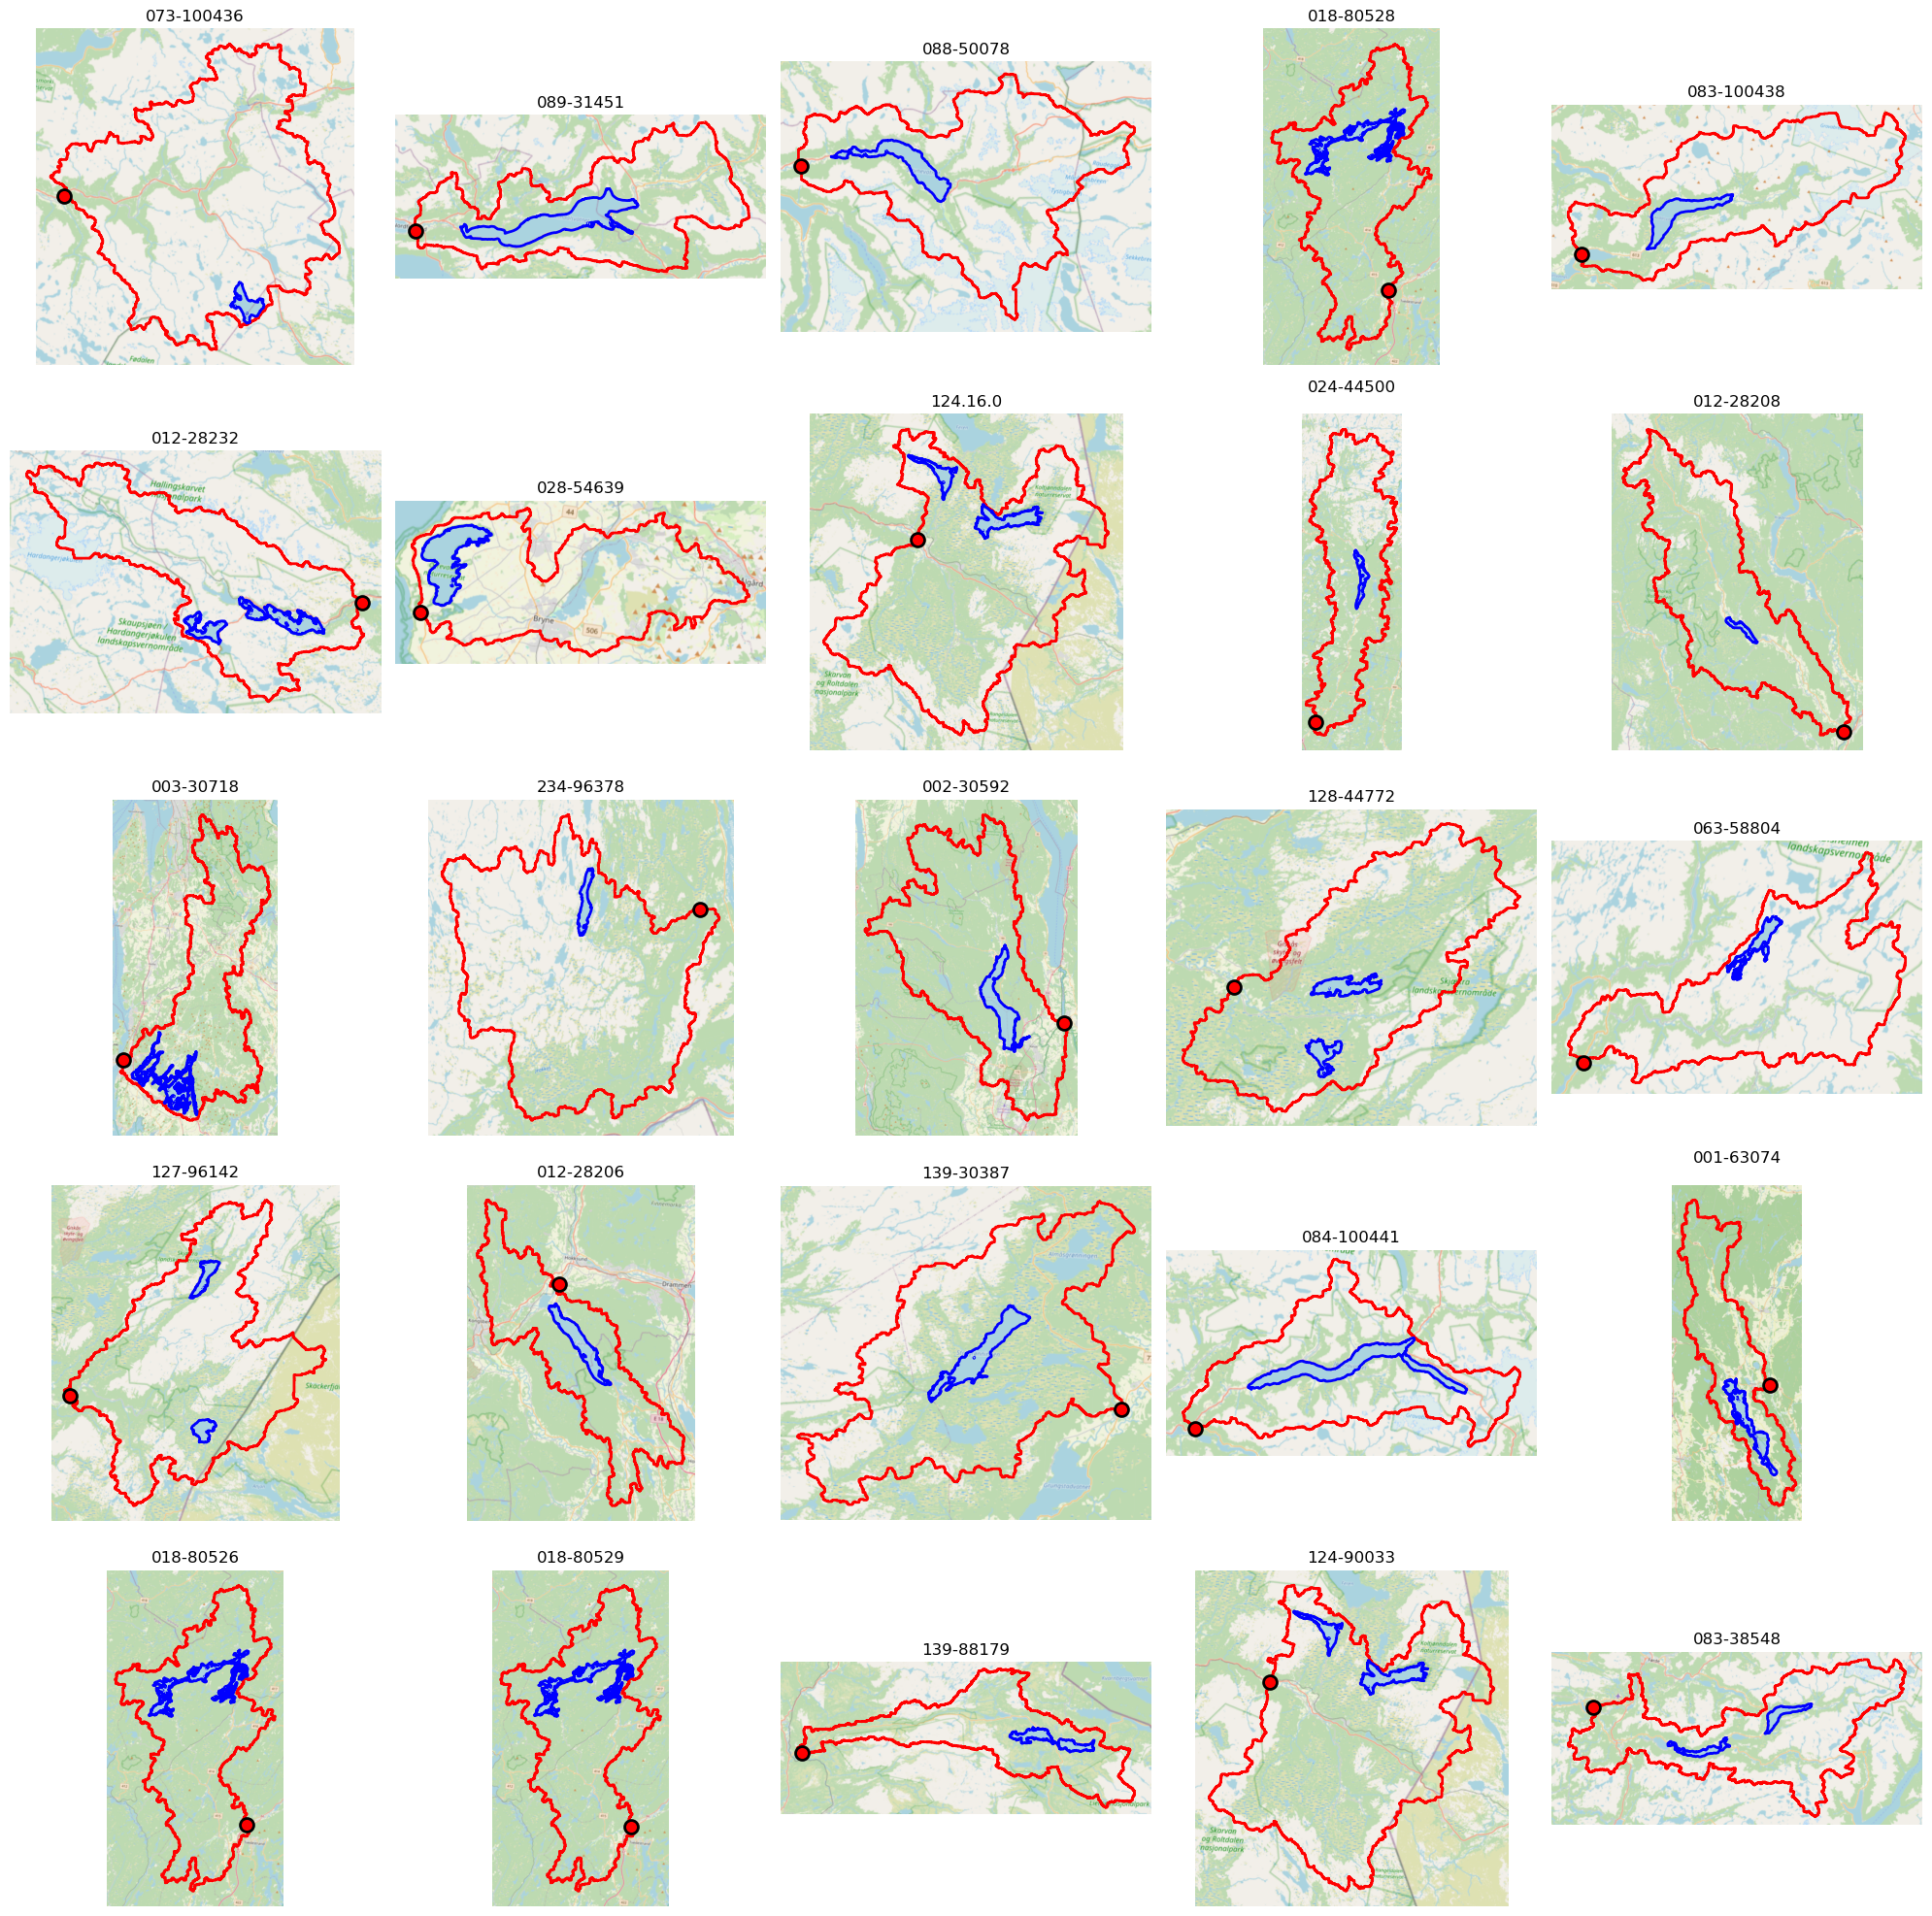

In [13]:
# Plot catchments with lakes upstream
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
axes = axes.flatten()

# Plot 25 of the excluded catchments at random for checking
check_cats = random.sample(cats_excl, 25)
for idx, stn_id in enumerate(check_cats):
    cat_poly = cat_gdf.query("station_id == @stn_id")
    stn_pt = stn_gdf.query("station_id == @stn_id")
    lake_poly = upstr_lake_gdf.query("station_id == @stn_id")

    cat_poly.plot(ax=axes[idx], facecolor="none", edgecolor="red", linewidth=2)
    stn_pt.plot(
        ax=axes[idx], facecolor="red", edgecolor="black", linewidth=2, markersize=100
    )
    lake_poly.plot(ax=axes[idx], facecolor="none", edgecolor="blue", linewidth=2)
    cx.add_basemap(
        axes[idx],
        crs=cat_poly.crs.to_string(),
        attribution=False,
        source=cx.providers.OpenStreetMap.Mapnik,
    )
    axes[idx].set_axis_off()
    axes[idx].set_title(stn_id)
plt.tight_layout()

In [14]:
# Remove catchments with upstream lakes from 'cat_gdf'
cat_gdf = cat_gdf.query("station_id not in @cats_excl")
print(
    f"{len(cat_gdf)} catchments with an upstream area < {upstr_area_thresh} "
    f"km2 and no upstream lakes > {upstr_lake_thresh} km2."
)

280 catchments with an upstream area < 1000 km2 and no upstream lakes > 5 km2.


### 4.3. Threshold based on urban and agricultural proportions

In [15]:
# Read AR50
ar50_gdb = os.path.join(data_fold, "land_cover", "nibio_ar50.gdb")
ar50_gdf = gpd.read_file(ar50_gdb, driver="fileGDB", layer="org_ar_ar50_flate")

print("Reclassifying...")
land_class_csv = r"https://raw.githubusercontent.com/NIVANorge/teotil3/main/data/ar50_artype_classes.csv"
artype_df = pd.read_csv(land_class_csv)
ar50_gdf = pd.merge(ar50_gdf, artype_df, how="left", on="artype")
ar50_gdf = ar50_gdf[["teotil", "geometry"]]

print("Reprojecting to equal area...")
cat_gdf_cea = cat_gdf.to_crs({"proj": "cea"})
ar50_gdf_cea = ar50_gdf.to_crs({"proj": "cea"})

print("Intersecting polygons...")
int_gdf = gpd.overlay(
    cat_gdf_cea, ar50_gdf_cea, how="intersection", keep_geom_type=True
)
int_gdf["area_km2"] = int_gdf["geometry"].area / 1e6

print("Aggregating...")
lc_df = int_gdf.groupby(["station_id", "teotil"]).sum(numeric_only=True)["area_km2"]
lc_df = lc_df.unstack("teotil")
lc_df.columns = [f"a_{i}_km2" for i in lc_df.columns]
lc_df.reset_index(inplace=True)
lc_df.columns.name = ""

cat_gdf = pd.merge(cat_gdf, lc_df, on="station_id", how="left")
cols = [
    "a_agri_km2",
    "a_glacier_km2",
    "a_lake_km2",
    "a_sea_km2",
    "a_upland_km2",
    "a_urban_km2",
    "a_wood_km2",
]
for col in cols:
    if col in cat_gdf.columns:
        cat_gdf[col] = cat_gdf[col].fillna(0)

# Get pct (urban + agri)
cat_gdf["a_anthrop_km2"] = cat_gdf["a_agri_km2"] + cat_gdf["a_urban_km2"]
cat_gdf["a_anthrop_pct"] = 100 * cat_gdf["a_anthrop_km2"] / cat_gdf["area_km2"]
del cat_gdf["a_other_km2"]

# Get just catchments where diffuse anthropogenic influence is low
n_anthrop = len(cat_gdf.query("a_anthrop_pct >= @anthrop_pct_thresh"))
cat_gdf = cat_gdf.query("a_anthrop_pct < @anthrop_pct_thresh")

print(
    f"\n{n_anthrop} catchments have a combined (urban + agricultural) land cover of >= {anthrop_pct_thresh} %.\n"
    f"These will be removed from the dataset. {len(cat_gdf)} catchments remain."
)

/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver OpenFileGDB does not support open option DRIVER
  result = ogr_read(


Reclassifying...
Reprojecting to equal area...
Intersecting polygons...
Aggregating...

149 catchments have a combined (urban + agricultural) land cover of >= 10 %.
These will be removed from the dataset. 131 catchments remain.


### 3.4. Check for point discharges

In [16]:
# Get point discharges of SS
df_list = []
for year in range(2013, 2024):
    for source in ["industry", "large wastewater"]:
        df_list.append(
            teo.io.get_raw_annual_point_data(
                eng,
                year,
                source,
                par_list=["ss_kg"],
            )
        )
pt_df = pd.concat(df_list, axis="rows")
pt_df["utm_zone"] = 33
pt_df = nivapy.spatial.utm_to_wgs84_dd(
    pt_df, zone="utm_zone", east="outlet_x_utm33", north="outlet_y_utm33"
)
pt_df = pt_df.query("SS_kg > 0")[["site_id", "lon", "lat"]].drop_duplicates()

# Identify any point discharges within catchments of interest
cats_with_pt = nivapy.spatial.identify_point_in_polygon(
    pt_df,
    cat_gdf,
    pt_col="site_id",
    poly_col="station_id",
    lat_col="lat",
    lon_col="lon",
).dropna(subset="station_id")

if len(cats_with_pt) > 0:
    cat_ids_to_drop = cats_with_pt["station_id"].unique().tolist()
    n_drop = len(cat_ids_to_drop)
    cat_gdf = cat_gdf.query("station_id not in @cat_ids_to_drop")
else:
    n_drop = 0

print(
    f"\n{n_drop} catchments contain point inputs.\n"
    f"These will be removed from the dataset. {len(cat_gdf)} catchments remain."
)


8 catchments contain point inputs.
These will be removed from the dataset. 123 catchments remain.


In [17]:
# Tidy catchments
cols = [
    "source",
    "station_id",
    "station_name",
    "lon",
    "lat",
    "area_km2",
    "a_agri_km2",
    "a_glacier_km2",
    "a_lake_km2",
    "a_upland_km2",
    "a_urban_km2",
    "a_wood_km2",
    "geometry",
]
cat_gdf = cat_gdf[cols].copy()

# Filter data to match
valid_cat_ids = cat_gdf["station_id"].unique().tolist()
stn_gdf = stn_gdf.query("station_id in @valid_cat_ids")
stn_df = stn_df.query("station_id in @valid_cat_ids")
df = df.query("station_id in @valid_cat_ids")
assert len(stn_df) == len(cat_gdf)
cat_df = cat_gdf.drop(columns="geometry")

display(stn_df.head())
display(df.head())
display(cat_df.head())

station_id          station_name        lon        lat source
3      38.1.0                Holmen   5.913059  59.498826    NVE
19   159.13.0      Engabreen kammer  13.793582  66.675663    NVE
22   12.565.0  Usta II kraftstasjon   8.410739  60.566894    NVE
50   159.13.1      Engabreen kammer  13.793582  66.675663    NVE
68   15.185.0                Moland   9.901651  59.072483    NVE

station_id       date   SS_mgpl
858   12.565.0 2007-01-02  0.002278
859   12.565.0 2007-01-03  0.104778
860   12.565.0 2007-01-04  0.061431
861   12.565.0 2007-01-05  0.208639
862   12.565.0 2007-01-06  0.216931

source station_id            station_name        lon        lat  \
5   Vannmiljø  001-30745  Enningdalselva (ENI 2)  11.490473  58.960694   
13  Vannmiljø  001-63067                   Børta  11.571798  59.940733   
27  Vannmiljø  002-29658     Kringlerdalen Leira  10.990661  60.236294   
36  Vannmiljø  002-30588     Leira ved Låkedalen  10.983158  60.208466   
46  Vannmiljø  002-56588    Mistra, hovedstasjon  11.200638  61.697210   

      area_km2  a_agri_km2  a_glacier_km2  a_lake_km2  a_upland_km2  \
5   210.655557    5.104657            0.0    3.487777      5.180024   
13    8.128802    0.033599            0.0    0.000000      0.065703   
27  263.295863    7.379622            0.0   15.249319     17.195124   
36  276.707880   12.148027            0.0   15.349489     17.579718   
46  553.107826    0.175816            0.0    6.020607    273.388439   

    a_urban_km2  a_wood_km2  
5      0.080217   71.814923  
13     0.000000    8.029500  
27     2.133142  221.338657  
36     2.870007  228.760639  
46     0.285414  273.237550

In [18]:
nivapy.spatial.quickmap(stn_df, popup="station_id", lon_col="lon", lat_col="lat")

In [19]:
cat_gdf.to_file(os.path.join(dir_path, "filtered_catchments.gpkg"))
with pd.ExcelWriter(os.path.join(dir_path, "filtered_data.xlsx")) as writer:
    df.to_excel(writer, sheet_name="data", index=False)
    stn_df.to_excel(writer, sheet_name="stations", index=False)
    cat_df.to_excel(writer, sheet_name="catchments", index=False)